In [12]:
!pip install wikipedia

  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11696 sha256=227864562cb4e35ae7ef2d507dfd01595d4d34f0dac0fb0e5364fba0d304e250
  Stored in directory: /root/.cache/pip/wheels/15/93/6d/5b2c68b8a64c7a7a04947b4ed6d89fb557dcc6bc27d1d7f3ba
Successfully built wikipedia


In [13]:
from keras.preprocessing.text import Tokenizer
from gensim.models.fasttext import FastText
import numpy as np
import matplotlib.pyplot as plt
import nltk
from string import punctuation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize
from nltk import WordPunctTokenizer

import wikipedia
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('english'))

%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Scraping Wikipedia Articles

In [17]:
artificial_intelligence = wikipedia.page("Artificial Intelligence").content
deep_learning = wikipedia.page("Deep Learning").content
neural_network = wikipedia.page("Neural Network").content

artificial_intelligence = sent_tokenize(artificial_intelligence)

deep_learning = sent_tokenize(deep_learning)
neural_network = sent_tokenize(neural_network)

artificial_intelligence.extend(deep_learning)
artificial_intelligence.extend(neural_network)

In [16]:
import re
from nltk.stem import WordNetLemmatizer

stemmer = WordNetLemmatizer()

def preprocess_text(document):
        # Remove all the special characters
        document = re.sub(r'\W', ' ', str(document))

        # remove all single characters
        document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)

        # Remove single characters from the start
        document = re.sub(r'\^[a-zA-Z]\s+', ' ', document)

        # Substituting multiple spaces with single space
        document = re.sub(r'\s+', ' ', document, flags=re.I)

        # Removing prefixed 'b'
        document = re.sub(r'^b\s+', '', document)

        # Converting to Lowercase
        document = document.lower()

        # Lemmatization
        tokens = document.split()
        tokens = [stemmer.lemmatize(word) for word in tokens]
        tokens = [word for word in tokens if word not in en_stop]
        tokens = [word for word in tokens if len(word) > 3]

        preprocessed_text = ' '.join(tokens)

        return preprocessed_text

In [18]:
sent = preprocess_text("Artificial intelligence, is the most advanced technology of the present era")
print(sent)


final_corpus = [preprocess_text(sentence) for sentence in artificial_intelligence if sentence.strip() !='']

word_punctuation_tokenizer = nltk.WordPunctTokenizer()
word_tokenized_corpus = [word_punctuation_tokenizer.tokenize(sent) for sent in final_corpus]


artificial intelligence advanced technology present


Creating Words Representation

In [19]:
embedding_size = 60
window_size = 40
min_word = 5
down_sampling = 1e-2

FastText model for word representations

In [20]:
%%time
ft_model = FastText(word_tokenized_corpus,
                      size=embedding_size,
                      window=window_size,
                      min_count=min_word,
                      sample=down_sampling,
                      sg=1,
                      iter=100)

CPU times: user 29 s, sys: 180 ms, total: 29.1 s
Wall time: 22.7 s


In [21]:
print(ft_model.wv['artificial'])

[ 0.02537264  0.46857327  0.17653975 -0.12928179  0.33534607  0.20207171
 -0.04849926  0.05615842 -0.50806886  0.06676991 -0.5884111   0.20698054
 -0.00236892 -0.5987402   0.37575063  0.00380009 -0.11191986 -0.20462564
 -0.427334   -0.0780983   0.25057784  0.5754518  -0.56745505 -0.3802436
 -0.16709518 -0.12686057 -0.36967093 -0.8017165   0.44835782  0.08244455
 -0.07203664 -0.57176656  0.09710449  0.27005142 -0.23565733  0.15679485
  0.14625564  0.27630293 -0.00924035 -0.41794756 -0.17625432 -0.12700813
 -0.29766458 -0.1531913  -0.639955   -0.36435914  0.0065724  -0.01871708
  0.4211318  -0.05533163 -0.05382402  0.00805327 -0.37172258 -0.4400924
 -0.19247128 -0.36170855  0.03264191  0.01786328  0.24209055 -0.15231793]


In [22]:
semantically_similar_words = {words: [item[0] for item in ft_model.wv.most_similar([words], topn=5)]
                  for words in ['artificial', 'intelligence', 'machine', 'network', 'recurrent', 'deep']}

for k,v in semantically_similar_words.items():
    print(k+":"+str(v))

artificial:['intelligence', 'superintelligence', 'autonomous', 'social', 'policy']
intelligence:['artificial', 'superintelligence', 'intelligent', 'creating', 'simulate']
machine:['ethic', 'ethical', 'study', 'reason', 'dartmouth']
network:['neural', 'convolutional', 'biological', 'depth', 'recurrent']
recurrent:['drug', 'network', 'neural', 'depth', 'current']
deep:['learning', 'specifically', 'scale', 'convolutional', 'industrial']


In [23]:
print(ft_model.wv.similarity(w1='artificial', w2='intelligence'))

0.6811368


Visualizing Word Similarities

In [24]:
from sklearn.decomposition import PCA

all_similar_words = sum([[k] + v for k, v in semantically_similar_words.items()], [])

print(all_similar_words)
print(type(all_similar_words))
print(len(all_similar_words))

['artificial', 'intelligence', 'superintelligence', 'autonomous', 'social', 'policy', 'intelligence', 'artificial', 'superintelligence', 'intelligent', 'creating', 'simulate', 'machine', 'ethic', 'ethical', 'study', 'reason', 'dartmouth', 'network', 'neural', 'convolutional', 'biological', 'depth', 'recurrent', 'recurrent', 'drug', 'network', 'neural', 'depth', 'current', 'deep', 'learning', 'specifically', 'scale', 'convolutional', 'industrial']
<class 'list'>
36


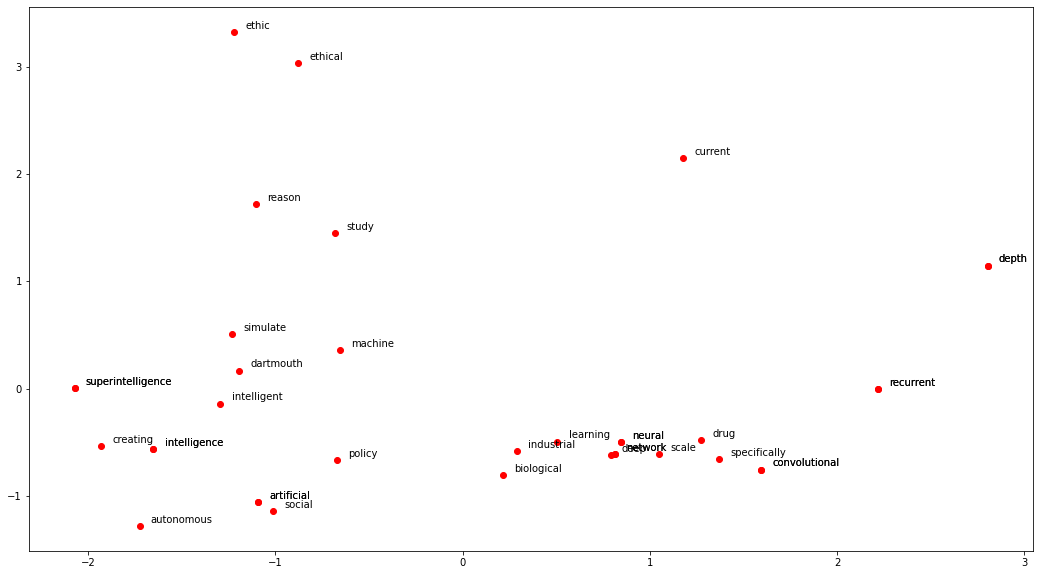

In [25]:
word_vectors = ft_model.wv[all_similar_words]

pca = PCA(n_components=2)

p_comps = pca.fit_transform(word_vectors)
word_names = all_similar_words

plt.figure(figsize=(18, 10))
plt.scatter(p_comps[:, 0], p_comps[:, 1], c='red')

for word_names, x, y in zip(word_names, p_comps[:, 0], p_comps[:, 1]):
    plt.annotate(word_names, xy=(x+0.06, y+0.03), xytext=(0, 0), textcoords='offset points')